# Tensor Regression Networks with ``TensorLy`` and ``gluon``

Let's now see how to combine TensorLy and MXNet in to implement the tensor regression networks, as defined in **Tensor Regression Network**, _Jean Kossaifi, Zachary C. Lipton, Aran Khanna, Tommaso Furlanello and Anima Anandkumar_, [ArXiV pre-publication](https://arxiv.org/abs/1707.08308).

We test the model on the MNIST dataset.

In [1]:
from __future__ import print_function
import mxnet as mx
from mxnet import nd, autograd
from mxnet.gluon import Block
from mxnet import gluon
import numpy as np

import tensorly as tl
from tensorly.random import check_random_state

mx.random.seed(1)

Using mxnet backend.


## Set the context

I am writing this tutorial from my Eurostar seat with limited access to the internet and only my laptop's CPU at hand, so CPU it is:

In [2]:
ctx = mx.cpu()

## Load the MNIST dataset

Here we simply load the MNIST dataset as a numpy array and split the training and testing into MXNet's NDArrayIter.

In [3]:
mnist = mx.test_utils.get_mnist()
batch_size = 64
num_outputs = 10
train_data = mx.io.NDArrayIter(mnist["train_data"], mnist["train_label"], batch_size, shuffle=True)
test_data = mx.io.NDArrayIter(mnist["test_data"], mnist["test_label"], batch_size, shuffle=True)

## Define the Tensor Regression Layer as a gluon Block

We wrap the code needed to perform low-rank tensor regression into a Gluon block so we can connect it to a deep convolutional net.

In [4]:
class TRL(Block):
    def __init__(self, ranks, n_outputs, in_shape=0, verbose=1, **kwargs):
        super(TRL, self).__init__(**kwargs)
        with self.name_scope():
            self.ranks = tuple(ranks)
            self.n_outputs = n_outputs
            self.weight_initializer = mx.init.Xavier(magnitude=2.24)
            self.core = self.params.get(
                'core', init=self.weight_initializer, 
                 shape=self.ranks)
            self.bias = self.params.get('bias', shape=(1, n_outputs))
            self.factors = [self.params.get(
                'factor_{}'.format(i), init=self.weight_initializer,
                 allow_deferred_init=True,
                 shape=(0, e)) for (i, e) in enumerate(ranks[:-1])]
            self.factors.append(self.params.get(
                'factor_{}'.format(len(ranks) - 1), init=self.weight_initializer,
                 shape=(n_outputs, ranks[-1])))
            self.initialised_factors = False
            self.verbose = verbose
            self.displayed_info = False

    def forward(self, x):
        if not self.initialised_factors:
            if self.verbose:
                print('TRL: initializing factors') 
            for i in range(len(self.ranks) - 1):
                self.factors[i].shape = (x.shape[i+1], self.ranks[i])
                self.factors[i]._finish_deferred_init()
            self.initialised_factors = True
            if self.verbose:
                print('  ..done.')
        
        if self.verbose and not self.displayed_info:
            print('TRL on input of shape={} with batch size={}.'.format(
                            x.shape[1:], x.shape[0], self.n_outputs))
            print('    TRL-rank={} corresponding to ({} [inputs], {} [outputs])'.format(
                            self.core.shape, x.shape[1:], self.n_outputs))
            self.displayed_info = True
            
        with x.context:
            regression_weights = tl.tucker_to_tensor(self.core.data(), [f.data() for f in self.factors])
            temp = nd.dot(x.reshape((0, -1)), nd.reshape(regression_weights, (-1, self.n_outputs)))
            return nd.broadcast_add(temp, self.bias.data())
        
    def penalty(self, order=2):
        penalty = tl.norm(self.core.data(), order)
        for f in self.factors:
            penatly = penalty + tl.norm(f.data(), order)
        return penalty
    
    @property
    def regression_weights(self):
        return tl.tucker_to_tensor(self.core.data(), [f.data() for f in self.factors])

# Define a Convolutional Net with a low-rank tensor regression output

In [5]:
net = gluon.nn.Sequential()
with net.name_scope():
    net.add(gluon.nn.Conv2D(channels=20, kernel_size=5, activation='relu'))
    net.add(gluon.nn.MaxPool2D(pool_size=2, strides=2))            
    net.add(gluon.nn.Conv2D(channels=50, kernel_size=5, activation='relu'))
    net.add(gluon.nn.MaxPool2D(pool_size=2, strides=2))
    # We keep a reference to the trl instance so we can refer to it later
    trl = TRL([10, 3, 3, 10], num_outputs)
    net.add(trl)

In [6]:
net.collect_params().initialize(mx.init.Xavier(magnitude=2.24), ctx=ctx)

softmax_cross_entropy = gluon.loss.SoftmaxCrossEntropyLoss()

trainer = gluon.Trainer(net.collect_params(), 'sgd', {'learning_rate': .1})

In [7]:
def evaluate_accuracy(data_iterator, net):
    acc = mx.metric.Accuracy()
    data_iterator.reset()
    for i, batch in enumerate(data_iterator):
        data = batch.data[0].as_in_context(ctx)
        label = batch.label[0].as_in_context(ctx)
        output = net(data)
        predictions = nd.argmax(output, axis=1)
        acc.update(preds=predictions, labels=label)
    return acc.get()[1]

In [8]:
epochs = 5
smoothing_constant = .01
rng = check_random_state(1) 
C = 0.001 # regularization

for e in range(epochs):
    train_data.reset()
    for i, batch in enumerate(train_data):
        data = batch.data[0].as_in_context(ctx)
        label = batch.label[0].as_in_context(ctx)
        with autograd.record():
            output = net(data)
            # We add a penalty, as defined in the TRL layer
            loss = softmax_cross_entropy(output, label) + C*trl.penalty()
        loss.backward()
        trainer.step(data.shape[0])
        
        curr_loss = nd.mean(loss).asscalar()
        moving_loss = (curr_loss if ((i == 0) and (e == 0)) 
                       else (1 - smoothing_constant) * moving_loss + (smoothing_constant) * curr_loss)
        
    test_accuracy = evaluate_accuracy(test_data, net)
    train_accuracy = evaluate_accuracy(train_data, net)
    print("Epoch %s. Loss: %s, Train_acc %s, Test_acc %s" % (e, moving_loss, train_accuracy, test_accuracy))    

TRL: initializing factors
  ..done.
TRL on input of shape=(50, 4, 4) with batch size=64.
    TRL-rank=(10, 3, 3, 10) corresponding to ((50, 4, 4) [inputs], 10 [outputs])
Epoch 0. Loss: 0.102192373141, Train_acc 0.972414712154, Test_acc 0.974820859873
Epoch 1. Loss: 0.0664897566447, Train_acc 0.982292777186, Test_acc 0.983180732484
Epoch 2. Loss: 0.0509061708328, Train_acc 0.986773720682, Test_acc 0.986464968153
Epoch 3. Loss: 0.0417029955412, Train_acc 0.989438965885, Test_acc 0.988256369427
Epoch 4. Loss: 0.0354006244203, Train_acc 0.990754930704, Test_acc 0.989052547771


Wasn't that easy?? :D

Should you want to, you can explore the learned regression weights:

In [9]:
trl.regression_weights.shape

(50, 4, 4, 10)

Or even plot them...

In [12]:
import matplotlib.pyplot as plt
%matplotlib inline

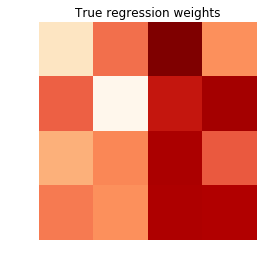

In [14]:
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
W = tl.to_numpy(trl.regression_weights)
ax.imshow(np.squeeze(W.mean(axis=0))[..., 0], cmap=plt.cm.OrRd, interpolation='nearest')
ax.set_axis_off()
ax.set_title('True regression weights')